In this notebook we analyse the regret for each method proposed to solve policy control when rewards are delayed, aggregate and anonymous.

To measure regret, we use a policy learned with full reward information each time step.

The measure of comparison is the average return over all runs at the final episode $K_{max}$, $G_{avg,K_{max}} = \frac{1}{K_{max}}\sum^{K_{max}}_{K=1} G_{k}$.

Then we average that across runs, and compute the returns ratio as: $\frac{\mu_{\bar{G}^{m}_{K}} - \mu_{\bar{G}^{FR}_{K}}}{\vert \mu_{\bar{G}^{FR}_{K}} \rvert}$.
It tells us the percentage difference in average return between the policy trained with algorithm $m$ compared to the full rewards policy.
Lower is better.

Key on methods:

  - "PP/FR": Full rewards information
  - "PP/IMR": Impute missing rewards (zero when absent)
  - "PP/LEAST-LFA": Reward estimation
  - "OP-A/FR": Options policy, with composition actions as options
  - "OP-S/FR": Options policy, with repeated single action as options

In [1]:
import copy
import os
import pathlib
from typing import Set

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
from drmdp import dataproc

In [4]:
import warnings # To suppress some warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [5]:
files = tf.io.gfile.glob(f"{pathlib.Path.home()}/fs/drmdp/workflows/controljob/agg/1746115037/1746166333/metrics/*.parquet")

In [6]:
df_metrics = dataproc.read_data(files)

2025-10-20 16:28:46,944	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Metadata Fetch Progress 0:   0%|                                                                              …

Parquet Files Sample 0:   0%|                                                                                 …

Read progress 0:   0%|                                                                                        …

In [7]:
df_metrics

,episode,exp_id,meta,returns,metrics,method
0,710,1746115037-00b9abcd-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[102.02783073563408, 104.33277137208779, 301.7...","{'returns': {'mean': 160.70075962951634, 'std'...",IMR
1,710,1746115037-01241eab-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[141.96122545991437, 158.30323632080845, 160.0...","{'returns': {'mean': 138.1951380766256, 'std':...",DMR
2,710,1746115037-19ac5573-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[14.36361851327176, 14.135411317837095, 14.485...","{'returns': {'mean': 94.14181259366002, 'std':...",DMR
3,710,1746115037-18a93f64-Finite-CC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[373.72272162757696, 372.6428221199749, 368.10...","{'returns': {'mean': 371.2849843573612, 'std':...",IMR
4,710,1746115037-0a19b809-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[53.40493990335529, 50.018484348888315, 52.417...","{'returns': {'mean': 50.97578817325536, 'std':...",OP-S
...,...,...,...,...,...,...
1079995,18350,1746115037-c693da3d-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-14.94479864857501, -15.733856465587706, -15....","{'returns': {'mean': -15.350051768296005, 'std...",IMR
1079996,18350,1746115037-cc958b03-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-14.06353877172906, -13.963707699852868, -13....","{'returns': {'mean': -14.053504804461154, 'std...",L-TRACE-Bayes
1079997,18350,1746115037-d1dd8368-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-33.336984360525314, -33.40777069369517, -33....","{'returns': {'mean': -33.382703939839786, 'std...",OP-A
1079998,18350,1746115037-f1d39cc9-RedGreen-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-12.8272028772274, -12.672824369244182, -10.2...","{'returns': {'mean': -11.906962381704904, 'std...",OP-A


In [8]:
df_metrics.iloc[0]["meta"]

{'context': {'dummy': 0},
 'exp_id': '1746115037-00b9abcd-Finite-SC-ShuntDc-v0',
 'instance_id': 9,
 'run_config': {'episodes_per_run': 1000,
  'log_episode_frequency': 10,
  'num_runs': 15,
  'output_dir': 'gs://mo-hendrix-ml-workflows-storage/drmdp/workflows/controljob/logs/1746115037/1746115037-00b9abcd-Finite-SC-ShuntDc-v0/run_9/zero-impute/f4cf45c3',
  'use_seed': True},
 'env_spec': {'args': {'constraint_violation_reward': 0.0,
   'max_episode_steps': 200.0,
   'penalty_gamma': 1.0,
   'reward_fn': 'pos-enf'},
  'feats_spec': {'args': None, 'name': 'scale'},
  'name': 'Finite-SC-ShuntDc-v0'},
 'epochs': 1,
 'problem_spec': {'delay_config': {'args': {'delay': 8.0}, 'name': 'fixed'},
  'epsilon': 0.2,
  'gamma': 1.0,
  'learning_rate_config': {'args': {'initial_lr': 0.01}, 'name': 'constant'},
  'policy_type': 'markovian',
  'reward_mapper': {'args': None, 'name': 'zero-impute'}},
 'reward_mapper': 'IMR',
 'policy_type': 'PP'}

In [9]:
df_metrics

,episode,exp_id,meta,returns,metrics,method
0,710,1746115037-00b9abcd-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[102.02783073563408, 104.33277137208779, 301.7...","{'returns': {'mean': 160.70075962951634, 'std'...",IMR
1,710,1746115037-01241eab-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[141.96122545991437, 158.30323632080845, 160.0...","{'returns': {'mean': 138.1951380766256, 'std':...",DMR
2,710,1746115037-19ac5573-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[14.36361851327176, 14.135411317837095, 14.485...","{'returns': {'mean': 94.14181259366002, 'std':...",DMR
3,710,1746115037-18a93f64-Finite-CC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[373.72272162757696, 372.6428221199749, 368.10...","{'returns': {'mean': 371.2849843573612, 'std':...",IMR
4,710,1746115037-0a19b809-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[53.40493990335529, 50.018484348888315, 52.417...","{'returns': {'mean': 50.97578817325536, 'std':...",OP-S
...,...,...,...,...,...,...
1079995,18350,1746115037-c693da3d-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-14.94479864857501, -15.733856465587706, -15....","{'returns': {'mean': -15.350051768296005, 'std...",IMR
1079996,18350,1746115037-cc958b03-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-14.06353877172906, -13.963707699852868, -13....","{'returns': {'mean': -14.053504804461154, 'std...",L-TRACE-Bayes
1079997,18350,1746115037-d1dd8368-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-33.336984360525314, -33.40777069369517, -33....","{'returns': {'mean': -33.382703939839786, 'std...",OP-A
1079998,18350,1746115037-f1d39cc9-RedGreen-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-12.8272028772274, -12.672824369244182, -10.2...","{'returns': {'mean': -11.906962381704904, 'std...",OP-A


In [10]:
envs = dataproc.get_distinct_envs(df_metrics)

In [11]:
envs

{'Finite-SC-ShuntDc-v0': {'constraint_violation_reward': 0.0,
  'max_episode_steps': 200.0,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-SC-PermExDc-v0': {'constraint_violation_reward': 0.0,
  'max_episode_steps': 200.0,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-CC-ShuntDc-v0': {'constraint_violation_reward': 0.0,
  'max_episode_steps': 200.0,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-TC-PermExDc-v0': {'constraint_violation_reward': 0.0,
  'max_episode_steps': 200.0,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'GridWorld-v0': {'constraint_violation_reward': None,
  'max_episode_steps': 200.0,
  'penalty_gamma': None,
  'reward_fn': None},
 'MountainCar-v0': {'constraint_violation_reward': None,
  'max_episode_steps': 2500.0,
  'penalty_gamma': None,
  'reward_fn': None},
 'Finite-CC-PermExDc-v0': {'constraint_violation_reward': 0.0,
  'max_episode_steps': 200.0,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'IceWorld-v0':

## Comparison: Regret - relative to full rewards observation

In [12]:
def parse_delay_config(df_input: pd.DataFrame):
    df = copy.deepcopy(df_input)
    def parse_mu(delay_config):
        if delay_config is None:
            return None
        args = delay_config["args"]
        try:
            return args["delay"]
        except KeyError:
            return args["lam"]
        except KeyError as exc:
            raise ValueError(f"Unknown delay config {args}") from exc
    df["delay_type"] = df["delay_config"].apply(lambda dc: dc["name"] if dc else None)
    df["delay_mu"] = df["delay_config"].apply(parse_mu)
    del df["delay_config"]
    return df

In [13]:
def max_episode_filter(df_input):
    env_spec = df_input["meta"].apply(lambda meta: meta["env_spec"])
    env_name = env_spec.apply(lambda spec: spec["name"])
    envs = env_name.unique()
    dfs = []
    for env in envs:
        df_slice = df_input[
            (env_name == env)
        ]
        df_slice = df_slice[df_slice["episode"] == df_slice["episode"].max()]
        dfs.append(
            copy.deepcopy(df_slice)
        )
    return pd.concat(dfs)
    

In [14]:
def calculate_regret_over_configurations(
    df_data
):    
    df_result = max_episode_filter(df_data)
    for key in ("delay_config", "gamma",):
        df_result[key] = df_result["meta"].apply(lambda meta: meta["problem_spec"][key])
    
    specs = {
        "env": df_result["meta"].apply(lambda meta: meta["env_spec"]),
        "feats": df_result["meta"].apply(lambda meta: meta["env_spec"]["feats_spec"])
    }
    
    for prefix, col_fam in specs.items():
        for col in ("name", "args"):
            df_result[f"{prefix}_{col}"] = col_fam.apply(lambda spec: spec[col])

    del df_result["meta"]    
    del df_result["exp_id"]
    
    def calc_regret(y_pred, y_oracle):
        # agg returns
        mean_y_oracle = np.mean(y_oracle)
        return (np.mean(y_pred) - mean_y_oracle) / np.abs(mean_y_oracle)

    rows = []
    keys = ["env_name", "gamma", "delay_config"]
    df_result = parse_delay_config(df_result)
    df_baseline = df_result[pd.isnull(df_result["delay_type"])]
    df_result = df_result[~pd.isnull(df_result["delay_type"])]
    
    baselines = {}
    for row in df_baseline.to_dict("records"):
        key = tuple(row[key] for key in keys[:-1])
        baselines[key] = row["returns"]

    for key in sorted(baselines.keys()):
        print(key)

    rows = []
    for row in df_result.to_dict("records"):
        key = tuple([row[key] for key in keys[:-1]])
        full_reward_mean_return = baselines[key]
        regret = calc_regret(y_pred=row["returns"], y_oracle = full_reward_mean_return)
        row["relative_regret"] = regret
        row["method"] = row["method"]
        rows.append(row)

    df_regret = pd.DataFrame(rows)
    df_regret = df_regret[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]].sort_values(
        ["env_name", "method", "delay_type", "delay_mu"]
    )
    return {"sarsa": df_regret}

In [15]:
METHODS_PALETTES = {
    key: palette for key, palette in zip(
        ["FR", "DMR", "IMR", "L-TRACE", "L-TRACE-Bayes", "OP-A", "OP-S"],
        sns.color_palette()
    )
}

In [16]:
METHODS_PALETTES

{'FR': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'DMR': (1.0, 0.4980392156862745, 0.054901960784313725),
 'IMR': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'L-TRACE': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'L-TRACE-Bayes': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'OP-A': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'OP-S': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

In [17]:
def plot_regret(df_data, suffix = None, method_filter_fn=lambda met: True, output_dir="figures/regret"):
    df_raw = copy.deepcopy(df_data[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]])
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]
    rps = sorted(df_raw["delay_mu"].unique())
    
    fig, axes = plt.subplots(
        nrows=1, ncols=len(rps), figsize=(4 * len(rps), 4), 
        sharey=False,
    )
    
    legend_shown = False
    for ax, rp in zip(axes.flatten(), rps):
        df_plot = df_raw[df_raw["delay_mu"] == rp]
        sns.boxplot(
            df_plot, 
            x="env_name", y="relative_regret", 
            hue="method",
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_title(f"Reward Delay, P = {rp}")
        if legend_shown is False:
            legend_shown = True
            ax.set_ylabel("Returns Ratio")
            ax.legend(loc='upper center', bbox_to_anchor=(len(rps) / 2.0, 1.3), ncol=3, fancybox=True)
        else:
            ax.set(ylabel=None)
            ax.legend().set_visible(False)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    name = f"regret_{suffix}.pdf"        
    path = os.path.join(output_dir, name)
    plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")  

In [18]:
dfs_regret = calculate_regret_over_configurations(df_metrics)

('Finite-CC-PermExDc-v0', 0.99)
('Finite-CC-PermExDc-v0', 1.0)
('Finite-CC-ShuntDc-v0', 0.99)
('Finite-CC-ShuntDc-v0', 1.0)
('Finite-SC-PermExDc-v0', 0.99)
('Finite-SC-PermExDc-v0', 1.0)
('Finite-SC-ShuntDc-v0', 0.99)
('Finite-SC-ShuntDc-v0', 1.0)
('Finite-TC-PermExDc-v0', 0.99)
('Finite-TC-PermExDc-v0', 1.0)
('GridWorld-v0', 0.99)
('GridWorld-v0', 1.0)
('IceWorld-v0', 0.99)
('IceWorld-v0', 1.0)
('MountainCar-v0', 0.99)
('MountainCar-v0', 1.0)
('RedGreen-v0', 0.99)
('RedGreen-v0', 1.0)


### SARSA

In [19]:
dfs_regret["sarsa"]

,env_name,method,delay_type,delay_mu,relative_regret
289,Finite-CC-PermExDc-v0,DMR,fixed,2.0,-0.090669
312,Finite-CC-PermExDc-v0,DMR,fixed,2.0,-0.095069
277,Finite-CC-PermExDc-v0,DMR,fixed,4.0,-0.153850
294,Finite-CC-PermExDc-v0,DMR,fixed,4.0,-0.065417
300,Finite-CC-PermExDc-v0,DMR,fixed,6.0,-0.092946
...,...,...,...,...,...
396,RedGreen-v0,OP-S,fixed,4.0,-30.387893
385,RedGreen-v0,OP-S,fixed,6.0,-45.987394
399,RedGreen-v0,OP-S,fixed,6.0,-17.579256
389,RedGreen-v0,OP-S,fixed,8.0,-36.113356


In [20]:
dfs_regret["sarsa"]["env_name"].unique()

array(['Finite-CC-PermExDc-v0', 'Finite-CC-ShuntDc-v0',
       'Finite-SC-PermExDc-v0', 'Finite-SC-ShuntDc-v0',
       'Finite-TC-PermExDc-v0', 'GridWorld-v0', 'IceWorld-v0',
       'MountainCar-v0', 'RedGreen-v0'], dtype=object)

In [21]:
sorted(dfs_regret["sarsa"]["delay_mu"].unique())

[2.0, 4.0, 6.0, 8.0]

In [22]:
dfs_regret["sarsa"].dtypes

env_name            object
method              object
delay_type          object
delay_mu           float64
relative_regret    float64
dtype: object

In [23]:
def filter_envs(df_input, envs: Set[str]):
    mask = df_input["env_name"].apply(
        lambda name: name in envs
    )
    return copy.copy(df_input[mask])

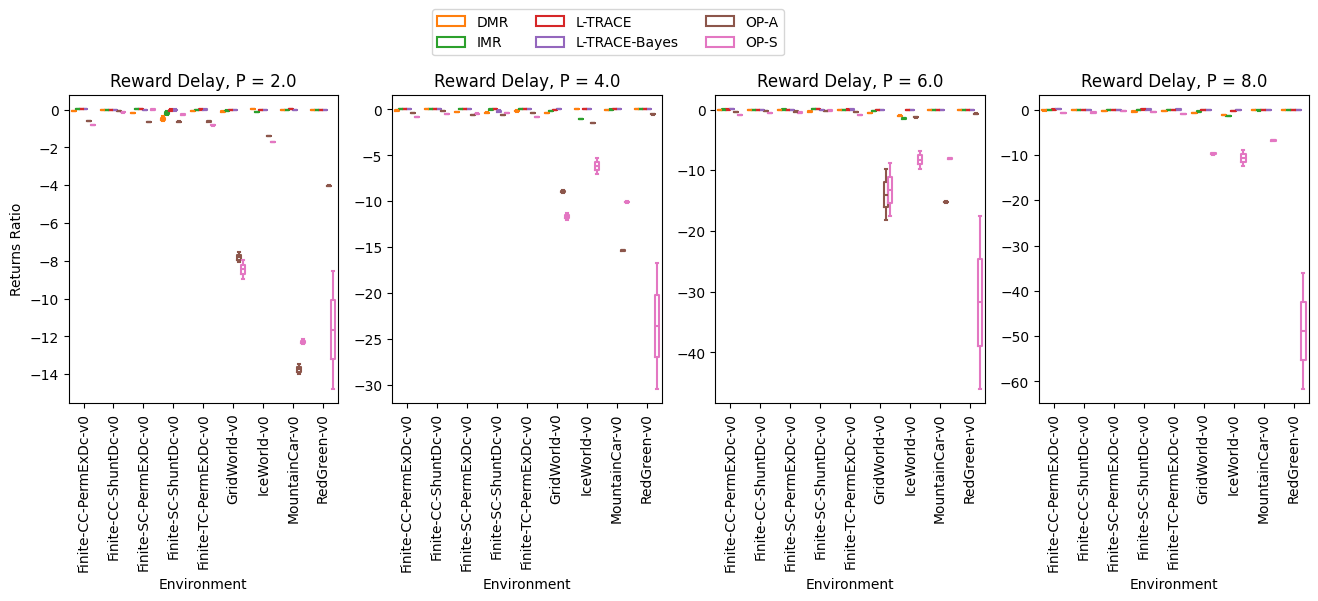

In [24]:
plot_regret(dfs_regret["sarsa"], suffix="sarsa")

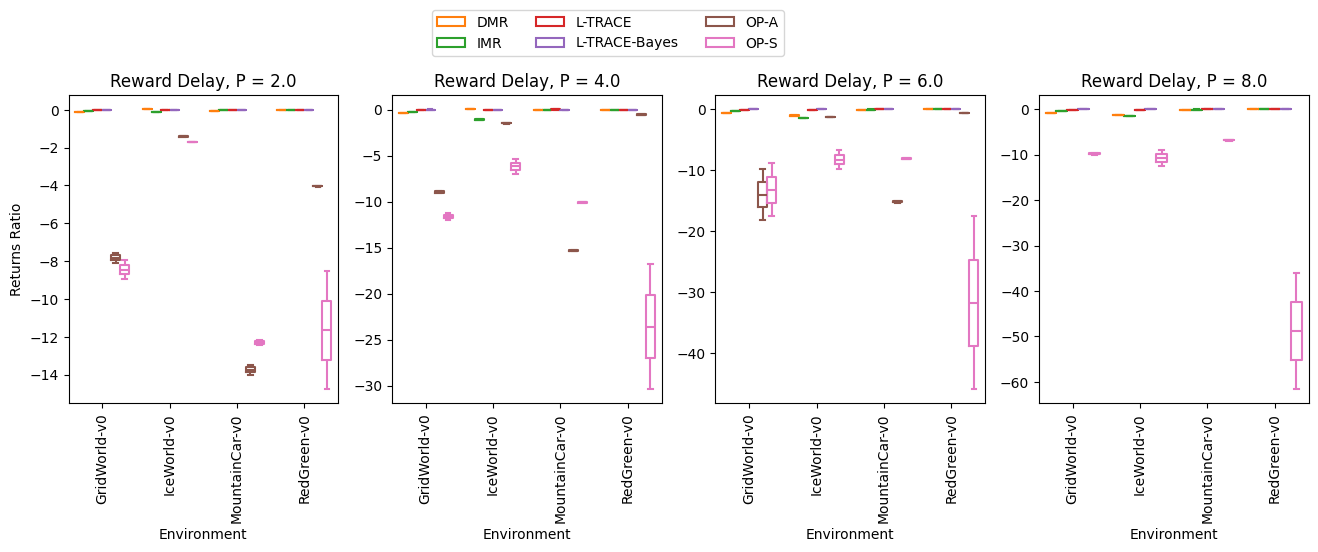

In [25]:
plot_regret(
    filter_envs(dfs_regret["sarsa"], envs=set(["GridWorld-v0", "IceWorld-v0", "MountainCar-v0", "RedGreen-v0"])),
    suffix="gym_sarsa"
)

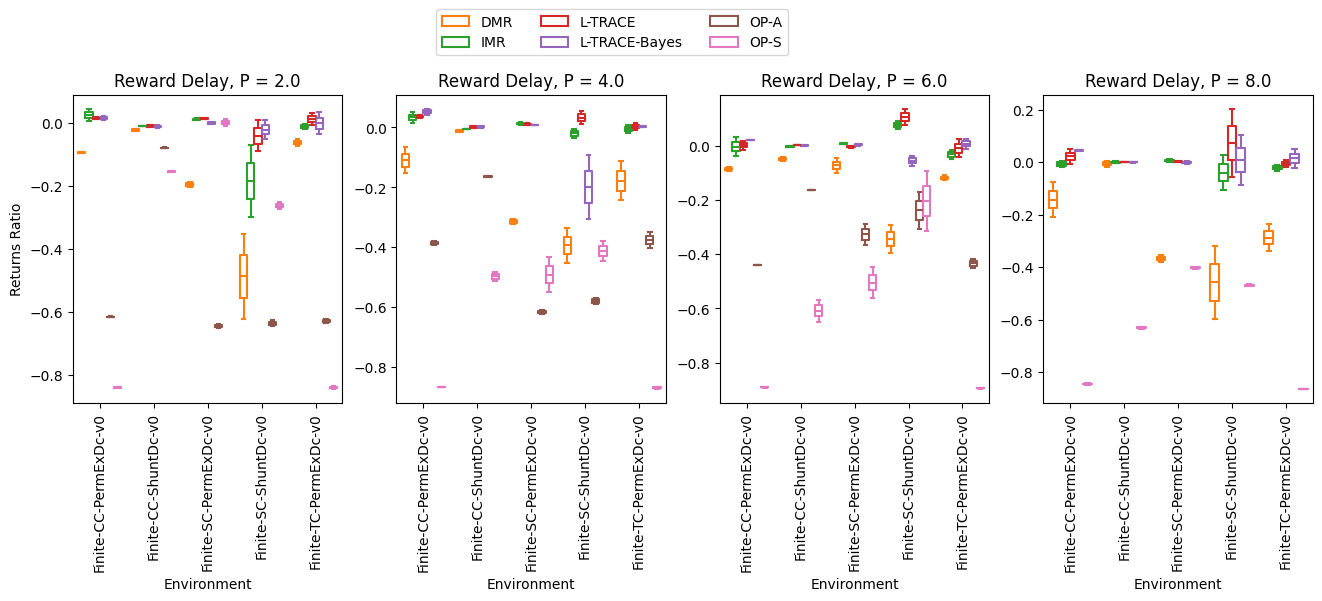

In [26]:
plot_regret(
    filter_envs(dfs_regret["sarsa"], 
                envs=set(["Finite-CC-PermExDc-v0", "Finite-CC-ShuntDc-v0", "Finite-SC-PermExDc-v0", "Finite-SC-ShuntDc-v0", "Finite-TC-PermExDc-v0"])),
    suffix="gem_sarsa"
)

## For Print

### Relative Regret - Returns Ratio

In [27]:
def print_regret(df_data, suffix = None, method_filter_fn=lambda met: True, output_dir="figures/regret"):
    df_raw = copy.deepcopy(df_data[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]])
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]
    rps = sorted(df_raw["delay_mu"].unique())
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for rp in rps:
        df_plot = df_raw[df_raw["delay_mu"] == rp]        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.boxplot(
            df_plot, 
            x="env_name", y="relative_regret", 
            hue="method",
            palette=METHODS_PALETTES,
            ax=ax,
            fill=False
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_ylabel("Returns Ratio")
        ax.set_title(f"Reward Period, P = {rp}")
        name = f"regret_{suffix}_rp{rp}.pdf"        
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

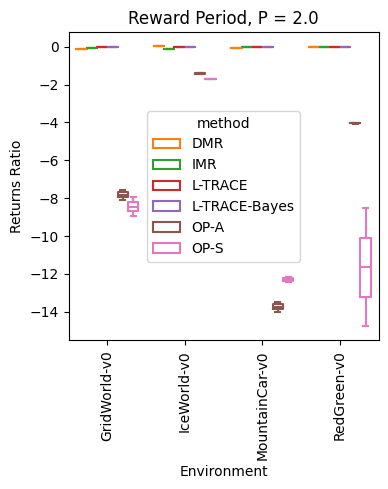

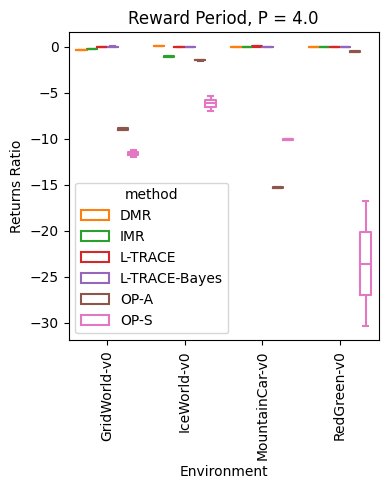

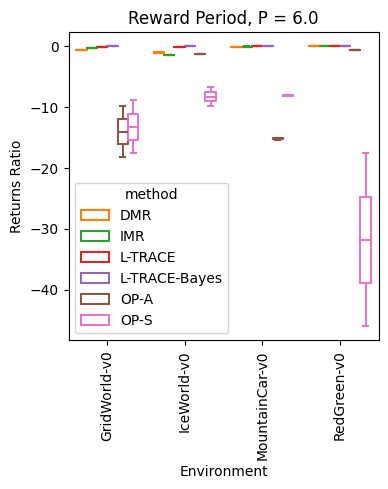

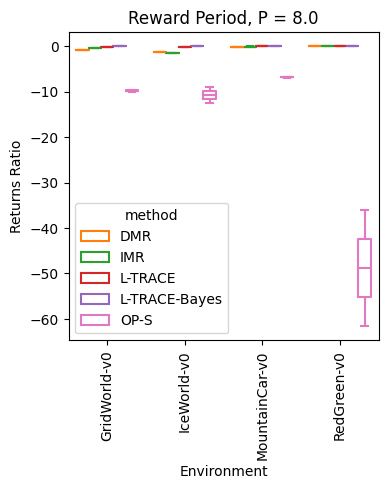

In [28]:
print_regret(
    filter_envs(dfs_regret["sarsa"], envs=set(["GridWorld-v0", "IceWorld-v0", "MountainCar-v0", "RedGreen-v0"])),
    suffix="gym_sarsa")

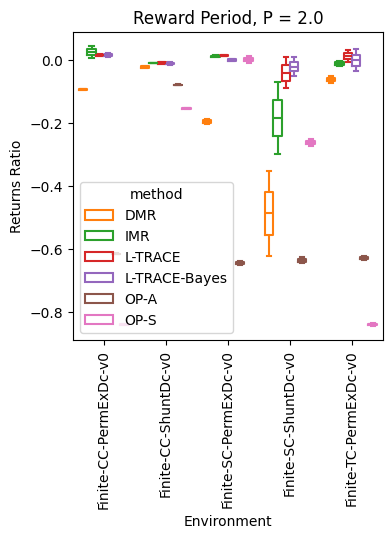

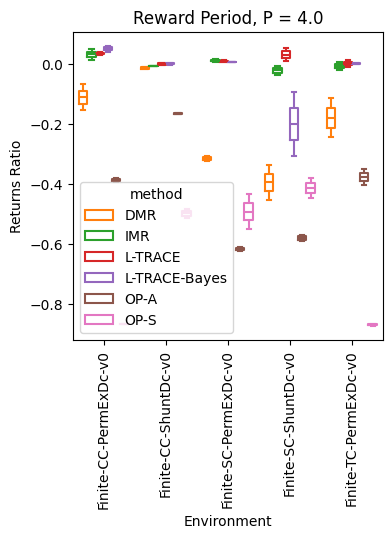

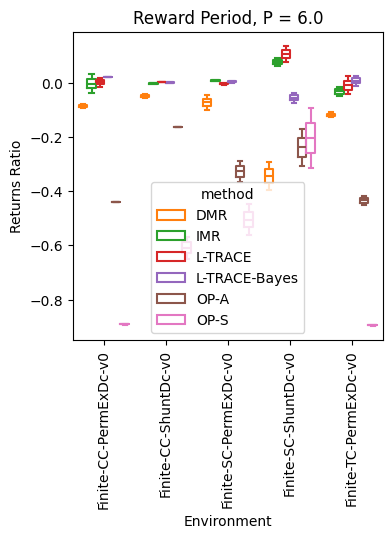

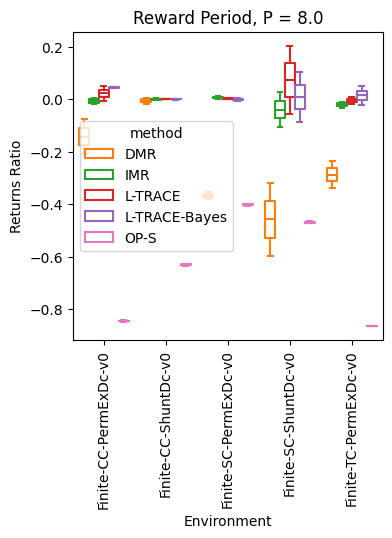

In [29]:
print_regret(
    filter_envs(dfs_regret["sarsa"], 
                envs=set(["Finite-CC-PermExDc-v0", "Finite-CC-ShuntDc-v0", "Finite-SC-PermExDc-v0", "Finite-SC-ShuntDc-v0", "Finite-TC-PermExDc-v0"])),
    suffix="gem_sarsa")

### Regret per Env

In [30]:
def plot_regret_dist(df_data, suffix, output_dir="figures/regret"):
    env_names = sorted(df_data["env_name"].unique())
    for env_name in env_names:
        df_slice = df_data[df_data["env_name"] == env_name]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.kdeplot(
            data=df_slice, 
            x="relative_regret", 
            hue="method", 
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax
        )
        ax.set_xlabel("Returns Ratio")
        ax.set_ylabel("Density")
        ax.set_title(f"Environment = {env_name}")
        name = f"regret_{suffix}_env_{env_name}.pdf"        
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

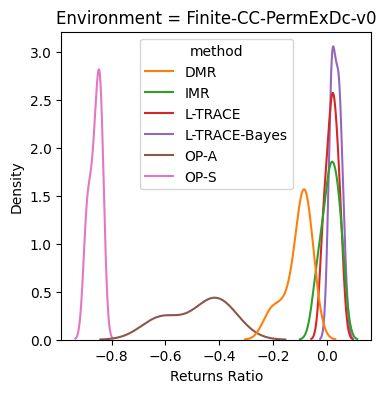

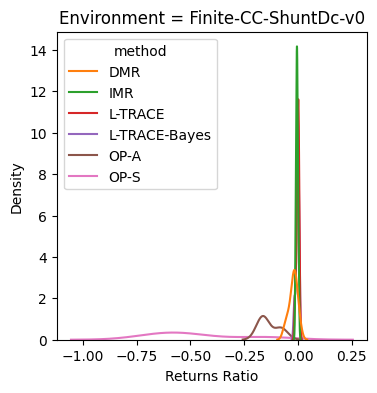

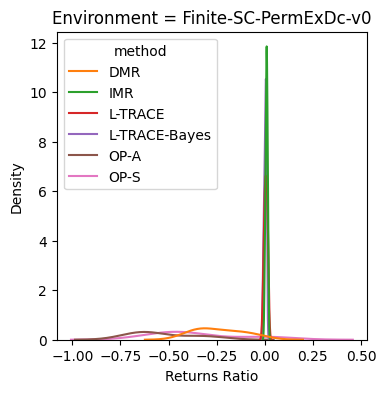

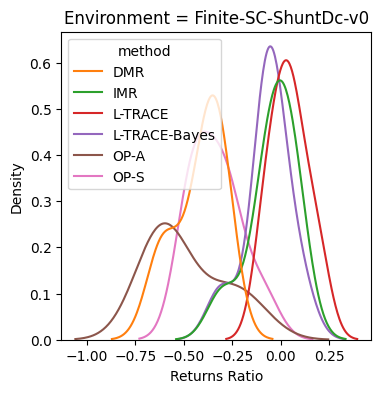

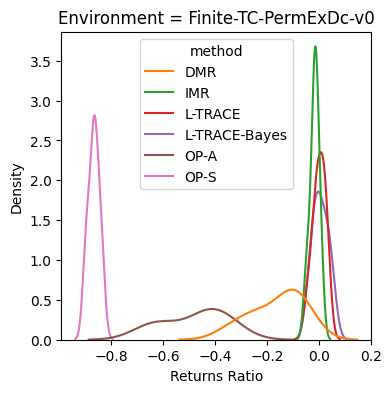

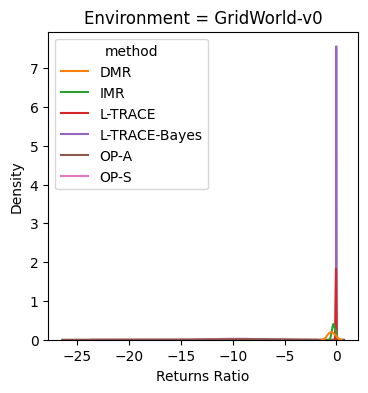

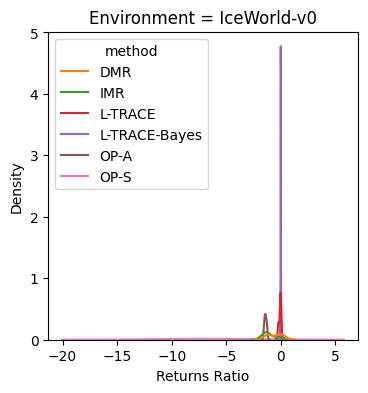

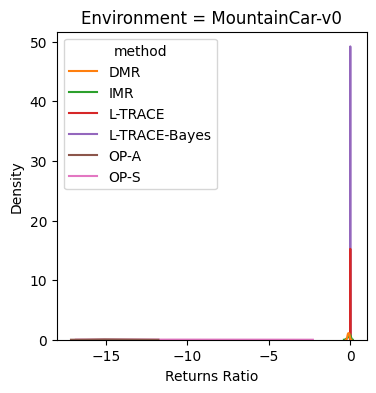

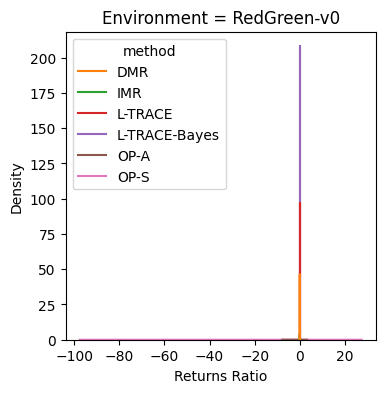

In [31]:
plot_regret_dist(dfs_regret["sarsa"], "sarsa")